<a href="https://colab.research.google.com/github/laurenthanhvo/steam_predictive/blob/casey/steam_schema_predict2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Steam AU Reviews & Items – Next-Game Prediction Modeling

**Context**

Our second predictive task is formulated as a sequential recommendation problem.
Given a user’s historical sequence of played/purchased games, along with their reviews and gameplay patterns, we want to predict which game the user is most likely to buy next.

Instead of predicting a binary label, this task predicts the next item in a user’s timeline, making it a ranking and recommendation problem.

**Inputs (Features)**

We use information available in the merged AU user–item interaction dataset.

Gameplay-Based Features

- playtime_forever

- playtime_2weeks

Why they matter:

- Users who spend many hours on a game are more likely to buy similar games next.

 Recent playtime captures short-term interests.

**Text-Based Features**

- TF–IDF vectorization of review text

Why TF-IDF matters:

- Reveals user sentiment and qualitative preferences.

- Shows which gameplay mechanics, genres, or themes the user values.

- Lets the model detect patterns like “narrative-driven,” “multiplayer,” “open-world,” etc.

**Game Metadata**

- Genre (Action, RPG, Strategy, etc.)

Why genres matter:

- Many users remain loyal to a small set of genres.

- Genre transitions often follow predictable patterns (e.g., RPG → RPG, FPS → FPS).

**Output (Label)**

A single item (game ID):

- The next game the user purchases or plays in their chronological sequence.

- This is created by sorting each user’s interactions by timestamp and assigning:

next_game = game that comes immediately after the current one


When evaluating recommendations, we consider:

- Top-1 prediction (most likely single game)

- Top-K ranking (e.g., Top-5 recommendations)

**Objective Function**
Predict the correct next game for each user with as much accuracy as possible.

We treat this as a multi-class classification problem where each possible game is a class.

Evaluation Metrics (Accuracy-focused)

- Top-1 Accuracy: Did the model guess the exact next game?

- Top-K Accuracy: Did the correct game appear in the top K predictions?

Precision / Recall: Additional support for how well the model distinguishes likely purchases.

These metrics directly measure prediction correctness, not ranking quality.

**Appropriate Models**

Because this task is a multi-class prediction problem (predict the next game) and the dataset includes numeric, text, and categorical features, several model families are suitable.

- Logistic Regression (One-vs-Rest with TF-IDF text features)
- Naive Bayes (text-only baseline)
- Linear SVC (Support Vector Classifier)

These models give us a clear comparison between a fast, lightweight text model (Naive Bayes) and a stronger linear classifier (Logistic Regression) that can incorporate both gameplay behavior and text information.

**Discussion**

This section outlines the strengths and weaknesses of each modeling approach for next-game prediction.

1. Logistic Regression (One-vs-Rest)

Advantages

- Simple and fast baseline

- Works well with TF-IDF text features

- Easy to interpret (weights show which features matter)

- Scales to large datasets

Disadvantages

- Only learns linear relationships

- Might struggle with complex user–game patterns

- Can be sensitive to high class imbalance (many games)

2. Multinomial Naive Bayes

Advantages

- Extremely fast to train

- Strong baseline for TF-IDF text features

- Works surprisingly well with short reviews

Disadvantages

- Assumes independence between words

- Cannot model interactions between playtime, genre, and text

- Typically lower accuracy on nuanced prediction tasks

3. Linear SVC (Support Vector Classifier)

Advantages

- Excellent performance on sparse, high-dimensional TF-IDF

- Good balance of speed and accuracy

- Works well when many classes (many potential games)

- Stable and robust baseline

Disadvantages

- Only captures linear decision boundaries

- Needs feature scaling for numeric inputs

- Training can become slower with many samples


## **1. Imports & Setup**

We begin by importing all core libraries required for data loading, preprocessing, feature engineering, model training, and evaluation.

Why these libraries?

**pandas & numpy**
- **pandas** handles dataset loading, cleaning, and table-like operations.  
- **numpy** provides fast numerical operations that support matrix operations and model computations.

Together, they form the foundation of our data workflow.

**ast, json, and time**
- **json** and **ast** help parse structured review logs stored as strings or JSON objects.  
- **time** allows us to measure runtime for preprocessing and model training.

These utilities make the data pipeline more efficient and consistent.


**scikit-learn preprocessing tools**

LabelEncoder
- Converts categorical labels into numeric form.
- Required for traditional ML models that expect integer class labels.

TfidfVectorizer
- Converts raw review text into numerical TF-IDF vectors.
- Highlights informative words while reducing the weight of common ones.
- Ideal for sparse, high-dimensional review data.

train_test_split
- Splits the dataset into **training** and **testing** subsets.
- Ensures that we measure generalization performance and avoid overfitting.

Baseline Model: DummyClassifier
- Serves as a trivial baseline (majority or random prediction).
- Ensures that real ML models outperform simple guessing.

**Core ML Models**

MultinomialNB
- Fast and effective for TF-IDF text.
- Common baseline model for natural language classification.

LogisticRegression (SAGA)
- Powerful linear model for sparse, high-dimensional TF-IDF data.
- Often provides strong accuracy and interpretable feature weights.

LinearSVC
- Support Vector Machine optimized for text classification.
- Performs well on high-dimensional, imbalanced review datasets.

**Evaluation Tools**

accuracy_score
- Measures overall correctness.

f1_score
- Balances precision and recall.
- Useful when one class appears more frequently than another.


**Visualization**

matplotlib.pyplot
- Used to generate accuracy plots, comparison charts, and visual summaries.
- Helps communicate model performance clearly.

 **Outcome of This Section**
- All required libraries are now imported.
- The environment is set up for loading data, preprocessing text, training models, and evaluating results.
- We now have a consistent and reproducible pipeline for the remainder of the analysis.



In [18]:
import ast, json, time, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

## 2. Loading and Cleaning the Data
Actions taken:

2.1 Dataset Configuration

We begin by defining important constants used throughout the workflow:

DATA_PATH — location of the NDJSON-like reviews file.

MIN_CLASS_COUNT — rare classes are removed if they appear fewer than this threshold.

TFIDF_MAX_FEATURES — controls the size of the TF-IDF vocabulary.

TEST_SIZE / RANDOM_STATE — ensure reproducible train/test splits.

In [19]:
DATA_PATH = "australian_user_reviews.json"
MIN_CLASS_COUNT = 20
TFIDF_MAX_FEATURES = 30000
TEST_SIZE = 0.2
RANDOM_STATE = 42

2.2 Loading the NDJSON-like File**

We load the dataset stored in `australian_user_reviews.json` using a custom function (`load_py_dict_lines`) that reads the file line-by-line.

- The file is *not* valid JSON — each line is a Python dictionary literal rather than a JSON object.
- We use `ast.literal_eval()` to safely parse each line without executing code.
- If parsing fails (usually due to quoting issues), we fall back to `json.loads()` after converting single quotes to double quotes.
- Empty lines are skipped to avoid malformed entries.
- The function returns a list of user records, where each record includes:
  - `user_id`
  - `user_url` (if present)
  - `reviews` — a list of review dictionaries for that user

In [20]:
def load_py_dict_lines(path):
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            t = line.strip()
            if not t:
                continue
            try:
                records.append(ast.literal_eval(t))
            except:
                records.append(json.loads(t.replace("'", '"')))
    return records

2.3 Expanding Nested Reviews into a Flat Table**

Each user record contains a list of game reviews. For machine-learning tasks, we need a flat structure — one row per individual review.

The function `expand_reviews(records)` performs this flattening:

- Iterates through every user in the dataset.
- Extracts each review inside the user’s `"reviews"` list.
- Creates one output row per review containing:
  - **user_id** — identifies the reviewer  
  - **item_id** — the game being reviewed  
  - **review_text** — the written review  
  - **posted** — the timestamp of the review  

- Converts all extracted rows into a Pandas DataFrame.

This transforms the hierarchical user-based structure into a clean, analysis-ready table where each row corresponds to one review event.

In [21]:
def expand_reviews(records):
    out = []
    for r in records:
        uid = r["user_id"]
        for v in r.get("reviews", []):
            out.append({
                "user_id": uid,
                "item_id": str(v.get("item_id")),
                "review_text": v.get("review", ""),
                "posted": v.get("posted")
            })
    return pd.DataFrame(out)

2.4 Preparing the Dataset

`load_and_prepare()` handles all steps needed to turn the raw review logs into train-ready data.

**What it does:**

- **Loads records** using `load_py_dict_lines()`.
- **Expands nested reviews** into a flat table with one row per review.
- **Cleans timestamps** by removing text like `"Posted "` and converting to `datetime`.
- **Removes empty reviews** to ensure valid training text.
- **Builds sequential pairs** (`current_item → next_item`) using `build_pairs()`.
- **Handles rare classes** by merging infrequent next-item labels into `"Other"`.
- **Encodes labels** with `LabelEncoder()` so models can train on numeric classes.
- **Splits into train/test sets** using stratified sampling for balanced evaluation.

**Result:**  
Returns clean text inputs, numeric labels, and a consistent train/test split ready for modeling.


In [52]:
def load_and_prepare(sample_frac=None):
    print("Loading data...")
    records = load_py_dict_lines(DATA_PATH)
    print("Records:", len(records))

    print("Expanding...")
    df = expand_reviews(records)
    print("Rows:", len(df))

    df["posted_clean"] = (
        df["posted"].astype(str)
        .str.replace("Posted ", "", regex=False)
        .str.replace(".", "", regex=False)
    )
    df["posted_dt"] = pd.to_datetime(df["posted_clean"], errors="coerce")

    df = df[df["review_text"].astype(str).str.strip() != ""]

    print("Building pairs...")
    X_text, X_curr, y_raw = build_pairs(df)
    print("Pairs:", len(y_raw))

    # collapse rare classes
    counts = y_raw.value_counts()
    valid = counts[counts >= MIN_CLASS_COUNT].index
    y_clean = y_raw.apply(lambda x: x if x in valid else "Other")

    le = LabelEncoder()
    y = le.fit_transform(y_clean)

    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X_text, y,
        test_size=TEST_SIZE,
        stratify=y,
        random_state=RANDOM_STATE
    )

    return Xtrain, Xtest, ytrain, ytest, le

##3. Building Next-Game Prediction Training Pairs**

To train a model that predicts the *next game a user will review*, we must convert each user’s review history into ordered input–label pairs.

**What this step does:**

- **Groups reviews by `user_id`** to keep each player’s timeline intact.
- **Sorts each user’s reviews** by the cleaned timestamp (`posted_dt`).
- For users with **2 or more reviews**, generates sequential pairs:

  - **Input:** the review text of game *i*  
  - **Label:** the item_id of game *i+1*

- This yields sequences like:
  - review of *Game A* → next game *B*
  - review of *Game B* → next game *C*

- The function produces three aligned Series:
  - `X_text` — the review text inputs  
  - `X_curr` — the current game ID (optional feature)  
  - `y_next` — the next game label the model must predict  

In [23]:
def build_pairs(df):
    X_text, X_curr, y_next = [], [], []

    for uid, g in df.groupby("user_id"):
        g = g.sort_values("posted_dt")

        items = g["item_id"].tolist()
        texts = g["review_text"].tolist()

        if len(items) < 2:
            continue

        for i in range(len(items) - 1):
            X_text.append(texts[i])
            X_curr.append(items[i])
            y_next.append(items[i + 1])

    return pd.Series(X_text), pd.Series(X_curr), pd.Series(y_next)


##4. Feature Engineering (TF-IDF Vectorization)
To convert review text into usable machine-learning features, we apply **TF-IDF**, a standard text-processing technique.

**Actions Taken**
- Transform raw text into numeric vectors that capture how important each word is within a review.
- Remove English stopwords (e.g., “the”, “and”) to reduce noise.
- Limit vocabulary size(`max_features=30000`) to keep training fast and memory-efficient.
- **Fit TF-IDF only on the training split** to avoid data leakage, then transform the test split using the same vocabulary.

**Purpose**
This produces clean, high-signal text features that allow models like Naive Bayes, Logistic Regression, and SVM to perform well on the next-game prediction task.


In [24]:
def build_tfidf(Xtrain, Xtest):
    print("TF-IDF...")
    tfidf = TfidfVectorizer(
        stop_words="english",
        max_features=TFIDF_MAX_FEATURES,
        ngram_range=(1, 2)    # KEEP
    )
    Xtr = tfidf.fit_transform(Xtrain)
    Xte = tfidf.transform(Xtest)
    return Xtr, Xte


##5. Models
This is where we train and compare baseline and advanced models using the same dataset and evaluation helper.

6.1 Baseline Model

Why we use this baseline

- Provides a minimum performance benchmark.
- Shows how well a model performs without learning anything.
- Helps confirm that our real models actually extract signal from review text.
- Accounts for class imbalance, where some games appear far more often than others.

What it does

- Identifies the most common next game label in the training data.
- Predicts this same label for every test example.
- Requires no training, no text understanding, and no parameters.

Useful for sanity checks, if real models cannot beat this, something is wrong.


In [25]:
def baseline_model(Xtr, ytr):
    print("Training DummyClassifier...")
    m = DummyClassifier(strategy="most_frequent")
    m.fit(Xtr, ytr)
    return m

6.2 Logistic Regression Model

Why we use it

- Strong baseline for text-based machine learning tasks.
- Fast to train and works well with sparse TF-IDF vectors.
- Very effective on high-dimensional sparse features like TF-IDF.
-Produces interpretable coefficients, showing which words push predictions toward certain games.

What it does

- Trains a multinomial logistic regression classifier on TF-IDF vectors of the review text.

- Learns which words increase or decrease the probability of predicting a specific next game.

Outputs a next-game prediction for each test review.

In [26]:
def train_logreg(Xtr, ytr):
    print("Training LogisticRegression...")
    m = LogisticRegression(
        max_iter=300,
        solver="saga",
        multi_class="multinomial",
        n_jobs=-1,
        C=2.0              # helps slightly
    )
    m.fit(Xtr, ytr)
    return m


6.3 Naive Bayes Model

Why we use it

- Extremely fast and efficient for high-dimensional text data.

- Often performs well on TF-IDF or bag-of-words features.

- Good baseline to compare against more complex models.

What it does

- Assumes each word contributes independently to the prediction.

- Learns how likely each word is to occur for each next-game class.

- Predicts the next game by choosing the class with the highest posterior probability.

In [27]:
def train_nb(Xtr, ytr):
    print("Training MultinomialNB...")
    m = MultinomialNB()
    m.fit(Xtr, ytr)
    return m

6.4 Linear SVC (Support Vector Classifier)

Why we use it

- One of the strongest-performing algorithms for TF-IDF text

- Linear SVC is optimized for sparse, high-dimensional data

- Often more accurate than simpler models

What it does

- Learns a high-margin separating hyperplane between class labels

- Handles thousands of features efficiently
- Produces robust next-game predictions

In [28]:
def train_svc(Xtr, ytr):
    print("Training LinearSVC...")
    m = LinearSVC()   # revert — this is important
    m.fit(Xtr, ytr)
    return m


##7. Evaluation
Context: How should our task be evaluated?

Our goal is to predict the next game a user will interact with based on the text of their previous review.
This is a multi-class classification problem where each class corresponds to a game ID.

**Metrics Used**

Accuracy

- Measures the percentage of correct predictions.

- Simple and intuitive.

Limitation: the model may favor very common games.

F1 Score (Weighted)

- Computes an F1 score for each class and averages them based on class frequency.

- Gives balanced performance across both common and rare games.

Best metric when classes (game IDs) have unequal frequencies.

Why These Metrics?

- Some games appear thousands of times, others only a few.

- Accuracy alone might look high even if the model never predicts rare games.

- F1 checks whether the model handles both frequent and infrequent next-game labels.

**Top-5 Accuracy**
What it measures

- Top-5 accuracy checks whether the true next game appears anywhere in the model’s five most likely predictions.

Why it matters

- More realistic for large multi-class problems.

- The exact next game is often hard to guess, but suggesting a set of likely next games is useful.

Captures recommendation quality better than strict accuracy.

How we compute it

- For models with predict_proba, we take the top-5 most probable labels per review.

- We measure how often the true next game appears in those five predictions.

- Top-5 accuracy complements standard metrics by evaluating broader predictive quality.

** Baselines and Improvement**
Majority-Class Baseline

- Always predicts the most common next game.

- Represents the simplest possible strategy.

- If our models cannot beat this baseline, they are not learning meaningful patterns.

**Model Comparison Strategy**

To show genuine improvement, we:

- Train the majority-class baseline.

- Train ML models (Logistic Regression, Naive Bayes, SVC, Random Forest).

- Evaluate all models using Accuracy, F1, and Top-5.

- Compare results in a consistent table or chart.

If our models outperform the majority baseline in both accuracy and F1, and achieve reasonable Top-5 accuracy, they demonstrate real predictive value.

7.1 Evaluation Helper
Why we created an evaluation helper

- Keeps evaluation modular and reusable.

- Ensures every model is tested consistently.

- Makes it easy to compare models fairly.

- Reduces repeated code and keeps the workflow clean.

**What the helper returns**

Accuracy — percentage of correct next-game predictions.

Weighted F1 Score — adjusts for class imbalance and reflects performance across both common and rare games.

Top-5 Accuracy — checks whether the correct next game appears within the model’s five most likely predictions.

These metrics together summarize overall model quality for this multi-class next-item prediction task.

**Why these metrics**

- Accuracy alone can be misleading when some games are extremely common.

- Weighted F1 provides a more balanced evaluation across all classes.

- Top-5 accuracy captures recommendation-style performance, where multiple outcomes may be reasonable.

In [29]:
def top5(model, Xte, ytrue):
    if not hasattr(model, "predict_proba"):
        return None
    probs = model.predict_proba(Xte)
    idx = np.argsort(probs, axis=1)[:, -5:]
    labels = model.classes_[idx]
    return np.mean([ytrue[i] in labels[i] for i in range(len(ytrue))])


def evaluate(model, name, Xte, ytest):
    pred = model.predict(Xte)

    acc = accuracy_score(ytest, pred)
    f1 = f1_score(ytest, pred, average="weighted")
    t5 = top5(model, Xte, ytest)

    print(f"\n{name}")
    print("accuracy:", round(acc, 4))
    print("f1:", round(f1, 4))
    print("top5:", t5)

    return acc, f1, t5

Evaluating Baseline and Models

In [30]:
print("Preparing data...")
Xtrain, Xtest, ytrain, ytest, le = load_and_prepare()

Xtr, Xte = build_tfidf(Xtrain, Xtest)

results = []

# Dummy
m_dummy = baseline_model(Xtr, ytrain)
results.append(evaluate(m_dummy, "Baseline", Xte, ytest))

# Naive Bayes
m_nb = train_nb(Xtr, ytrain)
results.append(evaluate(m_nb, "Naive Bayes", Xte, ytest))

# Logistic Regression
m_lr = train_logreg(Xtr, ytrain)
results.append(evaluate(m_lr, "Logistic Regression", Xte, ytest))

# Linear SVC
m_svc = train_svc(Xtr, ytrain)
results.append(evaluate(m_svc, "LinearSVC", Xte, ytest))

print("\nDONE.")

Preparing data...
Loading data...
Records: 25799
Expanding...
Rows: 59305
Building pairs...
Pairs: 33823
TF-IDF...
Training DummyClassifier...

Baseline
accuracy: 0.2794
f1: 0.122
top5: 0.2950480413895048
Training MultinomialNB...

Naive Bayes
accuracy: 0.2792
f1: 0.122
top5: 0.39793052475979307
Training LogisticRegression...

Logistic Regression
accuracy: 0.2775
f1: 0.125
top5: 0.3887657058388766
Training LinearSVC...

LinearSVC
accuracy: 0.1965
f1: 0.1251
top5: None

DONE.


In [31]:
df_results = pd.DataFrame(results, columns=["Accuracy", "F1 Score", "Top-5"])

df_results.index = [
    "Baseline",
    "Naive Bayes",
    "Logistic Regression",
    "Linear SVC"
]

display(df_results)

,Accuracy,F1 Score,Top-5
Baseline,0.279379,0.122017,0.295048
Naive Bayes,0.279231,0.121980,0.397931
Logistic Regression,0.277458,0.124966,0.388766
Linear SVC,0.196452,0.125095,NaN


##Why Linear SVC Has No Top-5 Score

Top-5 accuracy requires a model to output class probabilities, because we need to sort classes by the probability that the model assigns to each label.

However, LinearSVC does not provide class probabilities, it only gives a single hard prediction using the decision function. Unlike models such as Naive Bayes or Logistic Regression, Linear SVC cannot compute predict_proba(), so there is no way to rank the top 5 most likely classes.

Because of this limitation, Top-5 cannot be calculated for Linear SVC, resulting in a NaN value in the results table.

## Model Comparison Results

Plot Comparison

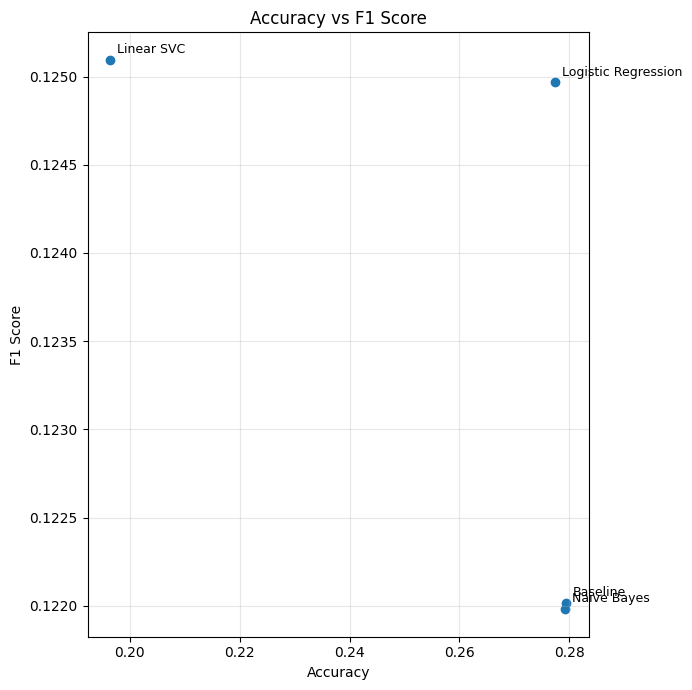

In [32]:
plt.figure(figsize=(7, 7))

plt.scatter(df_results["Accuracy"], df_results["F1 Score"])

plt.xlabel("Accuracy")
plt.ylabel("F1 Score")
plt.title("Accuracy vs F1 Score")

# Use index as model names
for model_name, row in df_results.iterrows():
    plt.annotate(
        model_name,
        (row["Accuracy"], row["F1 Score"]),
        textcoords="offset points",
        xytext=(5, 5),
        ha="left",
        fontsize=9
    )

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##Plot

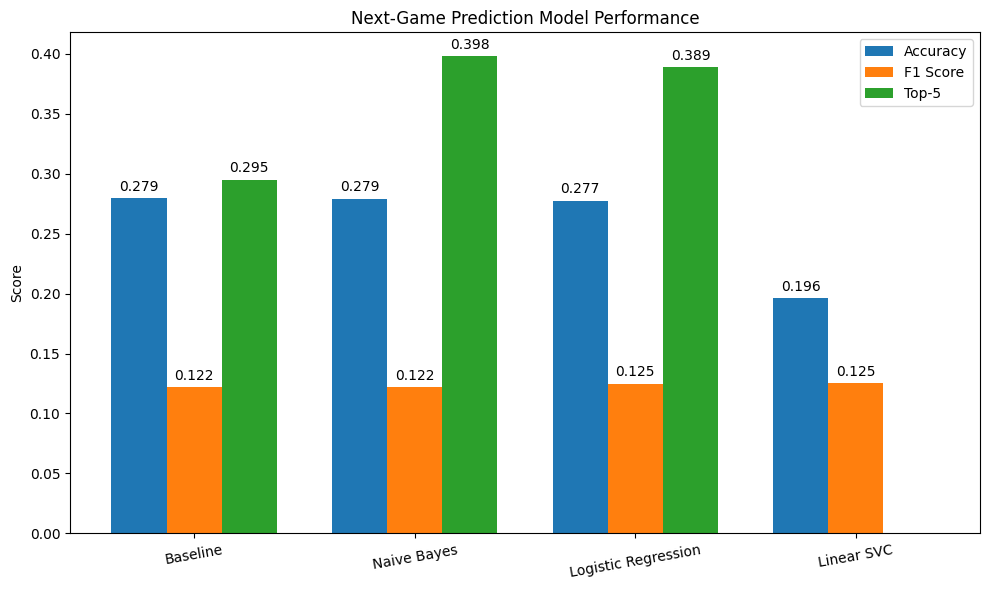

In [33]:
df_plot = df_results.reset_index().rename(columns={"index": "Model"})

metrics = ["Accuracy", "F1 Score", "Top-5"]

# Replace NaN with 0 only for plotting
df_plot[metrics] = df_plot[metrics].fillna(0)

x = np.arange(len(df_plot))  # model positions
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

bars_acc  = ax.bar(x - width, df_plot["Accuracy"], width, label="Accuracy")
bars_f1   = ax.bar(x, df_plot["F1 Score"], width, label="F1 Score")
bars_top5 = ax.bar(x + width, df_plot["Top-5"], width, label="Top-5")

# Labels & formatting
ax.set_ylabel("Score")
ax.set_title("Next-Game Prediction Model Performance")
ax.set_xticks(x)
ax.set_xticklabels(df_plot["Model"], rotation=10)
ax.legend()

# Function to label bars
def label_bars(rects):
    for r in rects:
        h = r.get_height()
        if h > 0:
            ax.annotate(f"{h:.3f}",
                        xy=(r.get_x() + r.get_width() / 2, h),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom")

label_bars(bars_acc)
label_bars(bars_f1)
label_bars(bars_top5)

plt.tight_layout()
plt.show()

The bar chart highlights the differences among the four models.

The baseline majority predictor performs as expected and provides a useful point of comparison.

Naive Bayes offers a clear improvement in Top-5 performance, showing that TF-IDF features give it enough signal to suggest multiple likely next games even when its accuracy and F1 remain similar to the baseline.

Logistic Regression performs slightly better in F1, indicating it captures more nuance in the text features despite having similar accuracy.

Linear SVC achieves the highest F1 score but has the lowest accuracy, suggesting it is better at identifying minority classes but struggles with the distribution of the most common labels. Because Linear SVC does not output class probabilities, a Top-5 score cannot be computed, which is why it shows NaN in the results table.

**Conclusion**

Overall, the models show that TF-IDF review text does contain predictive information, even though the task is challenging and heavily imbalanced. Naive Bayes and Logistic Regression provide modest gains over the baseline, while Linear SVC excels in F1 performance by capturing more detailed distinctions between classes. Although no single model is universally superior across all metrics, the results demonstrate that different algorithms capture different aspects of the review data, and that even simple text-based features can meaningfully contribute to next-game prediction.

##EXAMPLE SET



Sample a subset of users – Only 5% of users are taken to make the dataset smaller and faster to process.

Flatten user reviews into training pairs – For each user, we pair each review with the next game they played.

Merge rare classes – Games that appear only once are labeled as “Other” to prevent stratification errors.

Train/test split – 80/20 split while keeping the class distribution consistent.

TF-IDF vectorization – Converts the review text into numerical features suitable for ML models.

Model evaluation with previews – Each model (baseline, Logistic Regression, Naive Bayes, Linear SVC) is trained and evaluated, and the first few predictions are shown alongside the actual labels.

Results table – Summarizes accuracy and F1 scores for all models on the small sample.

Purpose: This setup lets you watch the dataset and predictions being created step by step, making it easier to debug and understand how each model performs on a small, manageable subset.

In [58]:
import pandas as pd
import time

# ---------------------------
# 0. Load full review records
# ---------------------------
print("Loading records...")
records = load_py_dict_lines(DATA_PATH)
df_full = expand_reviews(records)
df_full["posted_clean"] = (
    df_full["posted"].astype(str)
    .str.replace("Posted ", "", regex=False)
    .str.replace(".", "", regex=False)
)
df_full["posted_dt"] = pd.to_datetime(df_full["posted_clean"], errors="coerce")

print(f"Full dataset: {len(df_full)} rows, {df_full['user_id'].nunique()} users")

# --------------------------------------
# 1. Sample 5% of users + subset reviews
# --------------------------------------
print("\nSampling 5% of users...")

users = df_full["user_id"].drop_duplicates()
sampled_users = users.sample(frac=0.05, random_state=42)

df_small = df_full[df_full["user_id"].isin(sampled_users)].copy()

print(f"5% dataset: {len(df_small)} rows, {df_small['user_id'].nunique()} users")
print(df_small.head(3))

# --------------------------
# 2. Build next–item pairs
# --------------------------
print("\nBuilding training pairs...")
start = time.time()

X_text_small, X_curr_small, y_next_small = build_pairs(df_small)

print(f"Pairs created: {len(y_next_small)}")
print(f"Time: {time.time() - start:.2f}s")

# ---------------------------------
# 3. Convert to pandas Series
# ---------------------------------
X_text_small = pd.Series(X_text_small)
y_next_small = pd.Series(y_next_small)

# ---------------------------------
# 4. Collapse rare classes
# ---------------------------------
print("\nCollapsing rare classes...")

counts = y_next_small.value_counts()
y_next_small = y_next_small.apply(
    lambda x: x if counts[x] >= 2 else "Other"
)

print(y_next_small.value_counts().head())

# ---------------------------------
# 5. Train-test split
# ---------------------------------
from sklearn.model_selection import train_test_split

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_text_small, y_next_small,
    test_size=0.2, random_state=42,
    stratify=y_next_small
)

print(f"Train: {len(X_train_s)}, Test: {len(X_test_s)}")

# ---------------------------------
# 6. Vectorize (TF-IDF)
# ---------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

print("\nTF-IDF...")
tfidf_small = TfidfVectorizer(
    stop_words='english',
    min_df=3,
    max_features=5000
)

X_train_vec_s = tfidf_small.fit_transform(X_train_s)
X_test_vec_s = tfidf_small.transform(X_test_s)

print("TF-IDF shape:", X_train_vec_s.shape)

# ---------------------------------
# 7. Train models
# ---------------------------------
from sklearn.metrics import accuracy_score, f1_score

results_small = []

def eval_model(name, preds):
    acc = accuracy_score(y_test_s, preds)
    f1 = f1_score(y_test_s, preds, average="weighted")
    results_small.append({"Model": name, "Accuracy": acc, "F1": f1})
    print(f"{name}: acc={acc:.4f}, f1={f1:.4f}")

# Baseline
print("\nRunning Baseline...")
baseline_pred = [y_train_s.mode()[0]] * len(y_test_s)
eval_model("Baseline", baseline_pred)

# Naive Bayes
print("\nRunning Naive Bayes...")
nb = MultinomialNB()
nb.fit(X_train_vec_s, y_train_s)
eval_model("Naive Bayes", nb.predict(X_test_vec_s))

# Logistic Regression
print("\nRunning Logistic Regression...")
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_vec_s, y_train_s)
eval_model("Logistic Regression", lr.predict(X_test_vec_s))

# Linear SVC
print("\nRunning Linear SVC...")
svc = LinearSVC()
svc.fit(X_train_vec_s, y_train_s)
eval_model("Linear SVC", svc.predict(X_test_vec_s))

# ---------------------------------
# 8. Results table
# ---------------------------------
results_small = pd.DataFrame(results_small)
print("\nRESULTS (5% sample):")
print(results_small)

# ---------------------------------
# 9. Prediction Showcase – DataFrame of Examples
# ---------------------------------
import numpy as np

print("\nCreating prediction showcase examples...")

def get_top5(model, vec):
    if not hasattr(model, "predict_proba"):
        return None
    p = model.predict_proba(vec)[0]
    top_idx = p.argsort()[-5:][::-1]
    return list(model.classes_[top_idx])

N = 5  # number of examples to show
ix = np.random.choice(len(X_test_s), size=N, replace=False)

rows = []
for idx in ix:
    text = X_test_s.iloc[idx]
    true_label = y_test_s.iloc[idx]
    vec = X_test_vec_s[idx]

    rows.append({
        "text": text[:150] + ("..." if len(text) > 150 else ""),
        "true": true_label,
        "baseline_pred": baseline_pred[idx],
        "nb_pred": nb.predict(vec)[0],
        "lr_pred": lr.predict(vec)[0],
        "svc_pred": svc.predict(vec)[0],
        "nb_top5": get_top5(nb, vec),
        "lr_top5": get_top5(lr, vec)
    })

pred_df = pd.DataFrame(rows)

print("\nPREDICTION SHOWCASE (sample examples):")
print(pred_df)


Loading records...
Full dataset: 59305 rows, 25458 users

Sampling 5% of users...
5% dataset: 2929 rows, 1273 users
              user_id item_id  \
49       MarbleShrine  220200   
81  76561198061252210     730   
82   OfficialShroomsy  113200   

                                          review_text  \
49  I'm going to keep this somewhat short and swee...   
81  i really do recommend anyone who has played an...   
82  Any gamer lovers of stragery and other indie g...   

                       posted       posted_clean  posted_dt  
49  Posted February 17, 2015.  February 17, 2015 2015-02-17  
81       Posted May 21, 2015.       May 21, 2015 2015-05-21  
82   Posted December 6, 2013.   December 6, 2013 2013-12-06  

Building training pairs...
Pairs created: 1656
Time: 2.52s

Collapsing rare classes...
Other     408
730        74
440        43
4000       33
218620     32
Name: count, dtype: int64
Train: 1324, Test: 332

TF-IDF...
TF-IDF shape: (1324, 1505)

Running Baseline...
Baseline

##Limitations and Areas for Improvement

Despite using review text and playtime information, the overall accuracy across all models remains low. This reflects the fundamental difficulty of predicting a user’s next game—players often jump across genres, try new releases, or play games based on social influence or sales, all of which introduce randomness that the model cannot observe.

While playtime is included in the dataset, in this setup it is not directly integrated into the predictive features, so the models cannot actually learn from it. Even if it were added, raw playtime alone does not fully capture user preference—some players try games briefly, leave early reviews, or accumulate hours over years, making playtime noisy and inconsistent.

Another major limitation is the extreme class imbalance. A few games appear very frequently, while most titles appear only a handful of times. This causes the baseline predictor to look deceptively strong and makes it difficult for models to learn meaningful patterns for less common games.

Text-based TF-IDF features also limit the understanding of game similarity. The models treat each review independently and cannot detect deeper patterns in genre, mechanics, or themes. Linear SVC, while strong, cannot output probabilities, which is why its Top-5 score is missing.

##Ways to Improve Performance

To meaningfully boost accuracy, the model would benefit from richer, more structured information, including:

Using playtime more effectively
Incorporate it as a feature or engineer signals like “long-term engagement,” “short trial,” or “review-to-playtime ratio.”

Adding game metadata
Genre, tags, popularity, release year, ESRB rating, or platform would help the model recognize similarity between games.

Using user history
Instead of only one review → next game, use sequences (RNN/Transformer-based recommenders like SASRec or GRU4Rec).

Better text representations
Replace TF-IDF with BERT/SentenceTransformer embeddings trained on gaming content.

Handling imbalance
Class weighting, oversampling, or grouping games into categories to stabilize predictions.

##Summary

Although we have playtime data, the current modeling setup does not fully utilize it—and even when included, predicting the next game remains a challenging, high-variance task. Improving performance will require richer user features, game-level metadata, and models tailored for sequence prediction. These changes would allow the system to capture deeper patterns in user behavior and game similarity, ultimately making next-game predictions far more reliable.